In [2]:
import numpy as np 
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import functools
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
%matplotlib inline
# matplotlib is useful to create a static figure rather than plotly express.
import optuna
import scipy
from scipy.integrate import solve_ivp

In [3]:
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 12

In [43]:
def line_plot(df, title, ylabel="Cases", h=None, v=None):
    fig = plt.figure(figsize=(15, 8))
    ax = df.plot()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        ax.axvline(x=v, color="black", linestyle="--")
    plt.show()

In [5]:
raw = pd.read_csv("covid_19_data.csv")
datetime.now().strftime("%Y/%m/%d %H:%M:%S")

'2020/03/16 23:24:13'

In [6]:
raw.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
3079,3080,03/02/2020,"Umatilla, OR",US,2020-03-02T20:23:16,1.0,0.0,0.0
3080,3081,03/02/2020,From Diamond Princess,Australia,2020-02-29T02:03:10,0.0,0.0,0.0
3081,3082,03/02/2020,"Lackland, TX (From Diamond Princess)",US,2020-02-24T23:33:02,0.0,0.0,0.0
3082,3083,03/02/2020,"Omaha, NE (From Diamond Princess)",US,2020-02-24T23:33:02,0.0,0.0,0.0
3083,3084,03/02/2020,"Travis, CA (From Diamond Princess)",US,2020-02-24T23:33:02,0.0,0.0,0.0


In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 8 columns):
SNo                3084 non-null int64
ObservationDate    3084 non-null object
Province/State     2102 non-null object
Country/Region     3084 non-null object
Last Update        3084 non-null object
Confirmed          3084 non-null float64
Deaths             3084 non-null float64
Recovered          3084 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 192.9+ KB


In [8]:
raw.describe()

,SNo,Confirmed,Deaths,Recovered
count,3084.000000,3084.000000,3084.000000,3084.000000
mean,1542.500000,612.572633,17.466926,152.385214
std,890.418441,5092.995803,182.555887,1446.430660
min,1.000000,0.000000,0.000000,0.000000
25%,771.750000,2.000000,0.000000,0.000000
50%,1542.500000,10.000000,0.000000,1.000000
75%,2313.250000,121.000000,1.000000,18.000000
max,3084.000000,67103.000000,2803.000000,33934.000000


In [9]:
pd.DataFrame(raw.isnull().sum()).T

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,0,0,982,0,0,0,0,0


In [11]:
pprint(raw["Country/Region"].unique().tolist(), compact=True)

['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan', 'Thailand',
 'South Korea', 'Singapore', 'Philippines', 'Malaysia', 'Vietnam', 'Australia',
 'Mexico', 'Brazil', 'Colombia', 'France', 'Nepal', 'Canada', 'Cambodia',
 'Sri Lanka', 'Ivory Coast', 'Germany', 'Finland', 'United Arab Emirates',
 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others',
 'Egypt', 'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain',
 'Kuwait', 'Austria', 'Algeria', 'Croatia', 'Switzerland', 'Pakistan',
 'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark',
 'Estonia', 'Netherlands', 'San Marino', ' Azerbaijan', 'Belarus', 'Iceland',
 'Lithuania', 'New Zealand', 'Nigeria', 'North Ireland', 'Ireland',
 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
 'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
 'Morocco', 'Saudi Arabia', 'Senegal']


In [13]:
raw.loc[raw["Country/Region"] == "Others", :]

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
933,934,02/07/2020,Cruise Ship,Others,2020-02-07T16:33:03,61.0,0.0,0.0
1005,1006,02/08/2020,Cruise Ship,Others,2020-02-07T16:33:03,61.0,0.0,0.0
1077,1078,02/09/2020,Diamond Princess cruise ship,Others,2020-02-09T06:13:11,64.0,0.0,0.0
1143,1144,02/10/2020,Diamond Princess cruise ship,Others,2020-02-10T16:03:12,135.0,0.0,0.0
1215,1216,02/11/2020,Diamond Princess cruise ship,Others,2020-02-10T16:03:12,135.0,0.0,0.0
1286,1287,02/12/2020,Diamond Princess cruise ship,Others,2020-02-12T04:23:38,175.0,0.0,0.0
1359,1360,02/13/2020,Diamond Princess cruise ship,Others,2020-02-12T04:23:38,175.0,0.0,0.0
1433,1434,02/14/2020,Diamond Princess cruise ship,Others,2020-02-14T00:13:23,218.0,0.0,0.0
1506,1507,02/15/2020,Diamond Princess cruise ship,Others,2020-02-15T17:03:04,285.0,0.0,0.0
1578,1579,02/16/2020,Diamond Princess cruise ship,Others,2020-02-16T03:43:02,355.0,0.0,0.0


In [15]:
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Mortality rate", "Recovery rate"]

In [16]:
ncov_df = raw.rename({"ObservationDate": "Time", "Province/State": "Province", "Country/Region": "Country"}, axis=1)
ncov_df["Time"] = pd.to_datetime(ncov_df["Time"])
ncov_df["Country"] = ncov_df["Country"].replace({"Mainland China": "China"})
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace({"Cruise Ship": "Diamond Princess cruise ship "})
ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Time", "Country", "Province", *data_cols]]
ncov_df.tail()

,Time,Country,Province,Infected,Deaths,Recovered
3079,2020-03-02,US,"Umatilla, OR",1,0,0
3080,2020-03-02,Australia,From Diamond Princess,0,0,0
3081,2020-03-02,US,"Lackland, TX (From Diamond Princess)",0,0,0
3082,2020-03-02,US,"Omaha, NE (From Diamond Princess)",0,0,0
3083,2020-03-02,US,"Travis, CA (From Diamond Princess)",0,0,0


In [18]:
ncov_df.loc[ncov_df["Country"] == "Others", :]

,Time,Country,Province,Infected,Deaths,Recovered
933,2020-02-07,Others,Diamond Princess cruise ship,61,0,0
1005,2020-02-08,Others,Diamond Princess cruise ship,61,0,0
1077,2020-02-09,Others,Diamond Princess cruise ship,64,0,0
1143,2020-02-10,Others,Diamond Princess cruise ship,135,0,0
1215,2020-02-11,Others,Diamond Princess cruise ship,135,0,0
1286,2020-02-12,Others,Diamond Princess cruise ship,175,0,0
1359,2020-02-13,Others,Diamond Princess cruise ship,175,0,0
1433,2020-02-14,Others,Diamond Princess cruise ship,218,0,0
1506,2020-02-15,Others,Diamond Princess cruise ship,285,0,0
1578,2020-02-16,Others,Diamond Princess cruise ship,355,0,0


In [19]:
ncov_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 6 columns):
Time         3084 non-null datetime64[ns]
Country      3084 non-null object
Province     3084 non-null object
Infected     3084 non-null int32
Deaths       3084 non-null int32
Recovered    3084 non-null int32
dtypes: datetime64[ns](1), int32(3), object(2)
memory usage: 108.5+ KB


In [28]:
ncov_df.loc[ncov_df["Country"] == "South Korea", :]

,Time,Country,Province,Infected,Deaths,Recovered
37,2020-01-22,South Korea,-,1,0,0
75,2020-01-23,South Korea,-,1,0,0
121,2020-01-24,South Korea,-,2,0,0
162,2020-01-25,South Korea,-,2,0,0
208,2020-01-26,South Korea,-,3,0,0
255,2020-01-27,South Korea,-,4,0,0
306,2020-01-28,South Korea,-,4,0,0
358,2020-01-29,South Korea,-,4,0,0
413,2020-01-30,South Korea,-,4,0,0
468,2020-01-31,South Korea,-,11,0,0


In [32]:
ncov_df.describe(include="all").fillna("-")

,Time,Country,Province,Infected,Deaths,Recovered
count,3084,3084,3084,3084,3084,3084
unique,41,79,89,-,-,-
top,2020-03-02 00:00:00,China,-,-,-,-
freq,141,1265,982,-,-,-
first,2020-01-22 00:00:00,-,-,-,-,-
last,2020-03-02 00:00:00,-,-,-,-,-
mean,-,-,-,442.72,17.4669,152.385
std,-,-,-,3727.81,182.556,1446.43
min,-,-,-,0,0,0
25%,-,-,-,1,0,0


In [33]:
pd.DataFrame(ncov_df.isnull().sum()).T

,Time,Country,Province,Infected,Deaths,Recovered
0,0,0,0,0,0,0


In [34]:
pprint(ncov_df["Country"].unique().tolist(), compact=True)

['China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan', 'Thailand',
 'South Korea', 'Singapore', 'Philippines', 'Malaysia', 'Vietnam', 'Australia',
 'Mexico', 'Brazil', 'Colombia', 'France', 'Nepal', 'Canada', 'Cambodia',
 'Sri Lanka', 'Ivory Coast', 'Germany', 'Finland', 'United Arab Emirates',
 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others',
 'Egypt', 'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain',
 'Kuwait', 'Austria', 'Algeria', 'Croatia', 'Switzerland', 'Pakistan',
 'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark',
 'Estonia', 'Netherlands', 'San Marino', ' Azerbaijan', 'Belarus', 'Iceland',
 'Lithuania', 'New Zealand', 'Nigeria', 'North Ireland', 'Ireland',
 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
 'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia',
 'Morocco', 'Saudi Arabia', 'Senegal']


In [35]:
total_df = ncov_df.groupby("Time").sum()
total_df["Mortality rate"] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df["Recovery rate"] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df.tail()

,Infected,Deaths,Recovered,Mortality rate,Recovery rate
Time,,,,,
2020-02-27,46665,2814,33277,0.034004,0.402110
2020-02-28,44541,2872,36711,0.034140,0.436392
2020-02-29,43290,2941,39782,0.034193,0.462511
2020-03-01,42659,2996,42716,0.033903,0.483371
2020-03-02,41622,3085,45602,0.034160,0.504955


<Figure size 2160x1440 with 0 Axes>

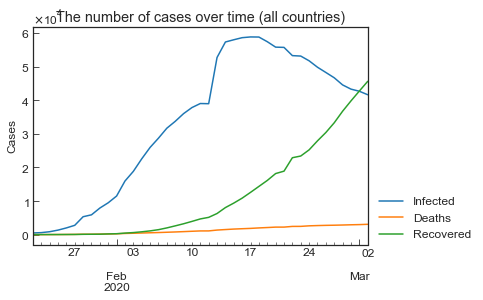

In [36]:
line_plot(total_df[data_cols], "The number of cases over time (all countries)")

<Figure size 2160x1440 with 0 Axes>

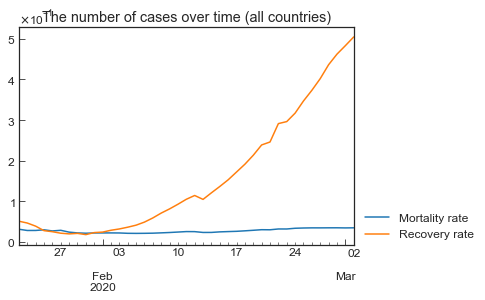

In [37]:
line_plot(total_df[rate_cols], "The number of cases over time (all countries)", ylabel="")

In [38]:
country_df = ncov_df.pivot_table(
    values="Infected", index="Time", columns="Country", aggfunc=sum
).fillna(0).astype(int)
country_df.head()

Country,Azerbaijan,Afghanistan,Algeria,Andorra,Armenia,Australia,Austria,Azerbaijan,Bahrain,Belarus,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UK,US,United Arab Emirates,Vietnam
Time,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,1,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3,0,1,0,2
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,5,0,2,0,2
2020-01-25,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,3,7,0,2,0,2
2020-01-26,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,4,6,0,5,0,2


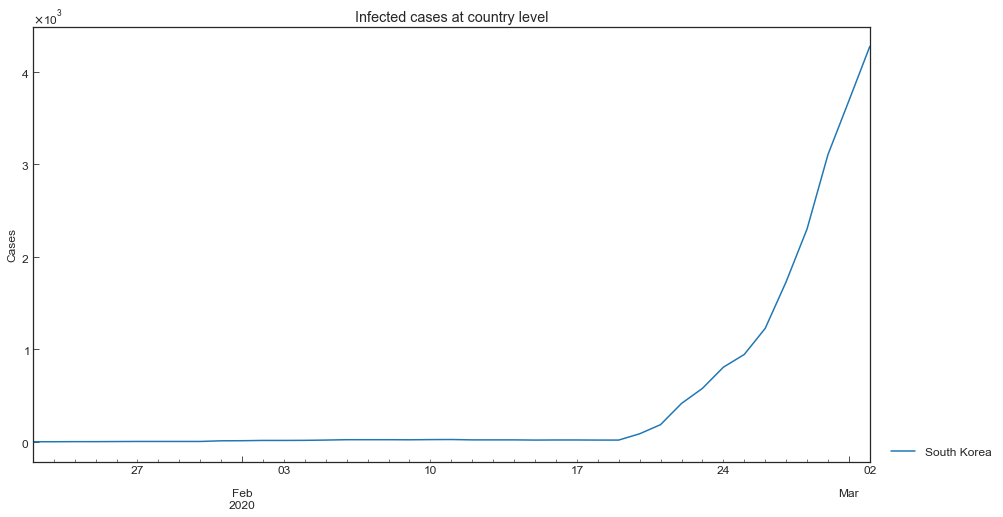

In [44]:
line_plot(country_df["South Korea"], title="Infected cases at country level")

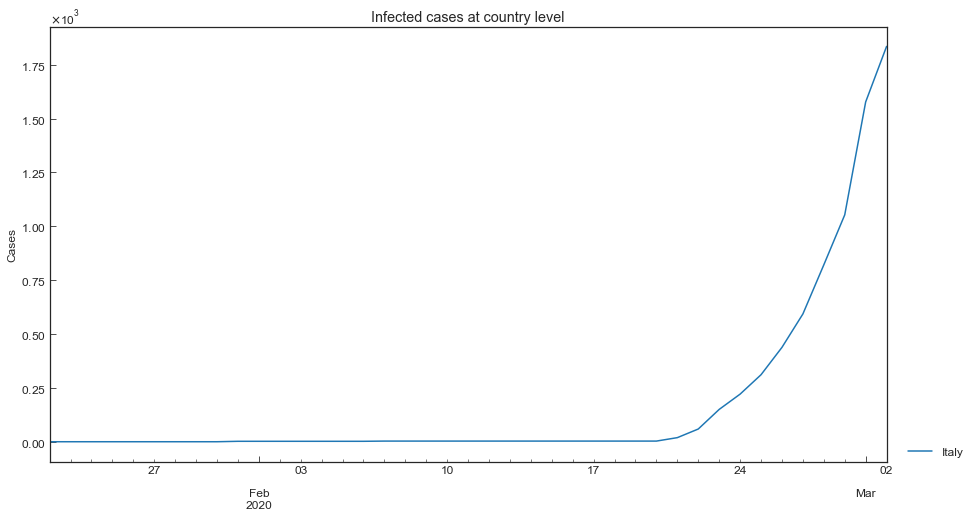

In [45]:
line_plot(country_df["Italy"], title="Infected cases at country level")

In [89]:
country_df.iloc[28, :] # 2월19일 시점의 Ro 와 파라미터 값 확인하기

Country
 Azerbaijan               0
Afghanistan               0
Algeria                   0
Andorra                   0
Armenia                   0
                       ... 
UK                        1
US                       12
United Arab Emirates      5
Vietnam                   9
Total except China      918
Name: 2020-02-19 00:00:00, Length: 80, dtype: int64

In [46]:
start_time = ncov_df.iloc[0, 0]
start_time

Timestamp('2020-01-22 00:00:00')

In [86]:
train_df = ncov_df.loc[
    (ncov_df["Country"] == "South Korea"),
    ["Time", *data_cols]
]
train_df = train_df.groupby("Time").mean().reset_index()
train_df["Elapsed"] = ((train_df["Time"] - start_time).dt.total_seconds() / 3600).astype(int)
train_df = train_df.loc[:, ["Elapsed", *data_cols]]
train_df.tail()

,Elapsed,Infected,Deaths,Recovered
36,864,1731,13,22
37,888,2302,13,22
38,912,3107,16,27
39,936,3689,17,30
40,960,4277,28,30


In [90]:
train_df = train_df.iloc[:29, :]
train_df.tail()

,Elapsed,Infected,Deaths,Recovered
24,576,19,0,9
25,600,20,0,9
26,624,20,0,10
27,648,19,0,12
28,672,19,0,12


<Figure size 1080x576 with 0 Axes>

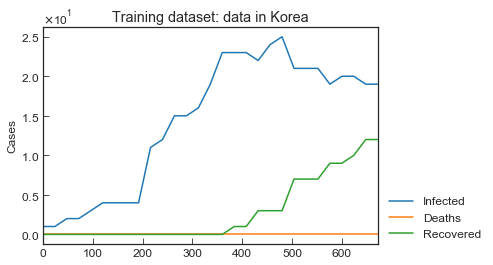

In [88]:
line_plot(train_df.set_index("Elapsed"), title="Training dataset: data in Korea")

In [109]:
N = korea_population = 51844627
N

51844627

In [110]:
train_df["T"] = train_df.loc[:29, "Elapsed"]
train_df["S"] = N - train_df.loc[:29, "Infected"] - train_df.loc[:29, "Deaths"] - train_df.loc[:29, "Recovered"]
train_df["I"] = train_df.loc[:29, "Infected"]
train_df["R"] = train_df.loc[:29, "Deaths"] + train_df.loc[:, "Recovered"]
train_df.tail()

,Elapsed,Infected,Deaths,Recovered,T,S,I,R,x,y,z
24,576,19,0,9,576,51844599,19,9,0.999999,3.664796e-07,1.735956e-07
25,600,20,0,9,600,51844598,20,9,0.999999,3.857680e-07,1.735956e-07
26,624,20,0,10,624,51844597,20,10,0.999999,3.857680e-07,1.928840e-07
27,648,19,0,12,648,51844596,19,12,0.999999,3.664796e-07,2.314608e-07
28,672,19,0,12,672,51844596,19,12,0.999999,3.664796e-07,2.314608e-07


<Figure size 1080x576 with 0 Axes>

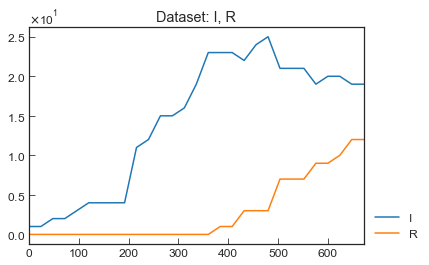

In [111]:
line_plot(train_df.set_index("T")[["I", "R"]], "Dataset: I, R", ylabel="")

In [112]:
train_df[["x", "y", "z"]] = train_df[["S", "I", "R"]] / N
train_df.head()

,Elapsed,Infected,Deaths,Recovered,T,S,I,R,x,y,z
0,0,1,0,0,0,51844626,1,0,1.0,1.928840e-08,0.0
1,24,1,0,0,24,51844626,1,0,1.0,1.928840e-08,0.0
2,48,2,0,0,48,51844625,2,0,1.0,3.857680e-08,0.0
3,72,2,0,0,72,51844625,2,0,1.0,3.857680e-08,0.0
4,96,3,0,0,96,51844624,3,0,1.0,5.786521e-08,0.0


In [113]:
class SIR(object):
    def __init__(self, rho, sigma, **kwargs):
        self.rho = float(rho)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        x, y, z = [X[i] for i in range(3)]
        dxdt = - self.rho * x * y
        dydt = self.rho * x * y - self.sigma * y
        dzdt = self.sigma * y
        # tf.stack
        return np.array([dxdt, dydt, dzdt])

In [114]:
def numerical_sir(initials, rho, sigma, tend, tstart=0, dt=1):
    sol_sir = scipy.integrate.solve_ivp(
        fun=SIR(rho=rho, sigma=sigma),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt)
    )
    sim_df = pd.DataFrame(
        {
            "t": sol_sir["t"],
            "x": sol_sir["y"][0],
            "y": sol_sir["y"][1],
            "z": sol_sir["y"][2]
        }
    )
    return sim_df

In [115]:
initials = train_df.loc[train_df.index[0], ["x", "y", "z"]].values
initials


array([9.99999981e-01, 1.92884019e-08, 0.00000000e+00])

# Hyperparameter optimization

* Using Optuna package, the three parameters ( ρ,σ  and  τ ) was estimated by model fitting.


In [116]:
def apply_tau(train_df, tau):
    df = train_df.copy()
    df["t"] = (df["T"] / tau).astype(int)
    df = df.loc[:, ["t", "x", "y", "z"]]
    return df

In [117]:
def error_f(train_df_divided, sim_df):
    # We need to minimize the difference of the observed values and estimated values
    df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
    diffs = [abs(df[f"{v}_observed"] - df[f"{v}_estimated"]).sum() for v in ("y", "z")]
    diff = sum(diffs)
    return diff

In [118]:
def target_f(train_df, initials, rho, sigma, tau):
    train_df_divided = apply_tau(train_df, tau)
    tend = train_df_divided.loc[train_df_divided.index[-1], "t"]
    sim_df = numerical_sir(initials, rho, sigma, tend, tstart=0, dt=1)
    return error_f(train_df_divided, sim_df)

In [119]:
def objective_with_param(trial, train_df, initials):
    rho = trial.suggest_uniform("rho", 0, 1)
    sigma = trial.suggest_uniform("sigma", 0, 1)
    tau = trial.suggest_int("tau", 1, 24)
    return target_f(train_df, initials, rho, sigma, tau)

In [120]:
objective = functools.partial(objective_with_param, train_df=train_df, initials=initials)

In [121]:
study = optuna.create_study(direction="minimize")

In [122]:
study.optimize(objective, n_trials=300)

[I 2020-03-17 00:00:37,993] Finished trial#0 resulted in value: 1.3801951947410756e-05. Current best value is 1.3801951947410756e-05 with parameters: {'rho': 0.4127390586753681, 'sigma': 0.7103023172953723, 'tau': 23}.
[I 2020-03-17 00:00:38,111] Finished trial#1 resulted in value: 9.857379034790609e-06. Current best value is 9.857379034790609e-06 with parameters: {'rho': 0.51199940294663, 'sigma': 0.6350905536494917, 'tau': 18}.
[I 2020-03-17 00:00:38,219] Finished trial#2 resulted in value: 4.628588555047324. Current best value is 9.857379034790609e-06 with parameters: {'rho': 0.51199940294663, 'sigma': 0.6350905536494917, 'tau': 18}.
[I 2020-03-17 00:00:38,327] Finished trial#3 resulted in value: 4.805225269767364. Current best value is 9.857379034790609e-06 with parameters: {'rho': 0.51199940294663, 'sigma': 0.6350905536494917, 'tau': 18}.
[I 2020-03-17 00:00:38,429] Finished trial#4 resulted in value: 9.039457140259924e-06. Current best value is 9.039457140259924e-06 with paramete

[I 2020-03-17 00:00:41,997] Finished trial#37 resulted in value: 2.0839340746884527e-05. Current best value is 9.039457140259924e-06 with parameters: {'rho': 0.03971415014415147, 'sigma': 0.05407470183833163, 'tau': 9}.
[I 2020-03-17 00:00:42,107] Finished trial#38 resulted in value: 1.888121640957838e-05. Current best value is 9.039457140259924e-06 with parameters: {'rho': 0.03971415014415147, 'sigma': 0.05407470183833163, 'tau': 9}.
[I 2020-03-17 00:00:42,216] Finished trial#39 resulted in value: 1.0052480716937256e-05. Current best value is 9.039457140259924e-06 with parameters: {'rho': 0.03971415014415147, 'sigma': 0.05407470183833163, 'tau': 9}.
[I 2020-03-17 00:00:42,325] Finished trial#40 resulted in value: 9.403160671710472e-06. Current best value is 9.039457140259924e-06 with parameters: {'rho': 0.03971415014415147, 'sigma': 0.05407470183833163, 'tau': 9}.
[I 2020-03-17 00:00:42,433] Finished trial#41 resulted in value: 0.00011965778119283721. Current best value is 9.039457140

[I 2020-03-17 00:00:46,160] Finished trial#74 resulted in value: 7.780165299643709e-06. Current best value is 5.6933594285299514e-06 with parameters: {'rho': 0.1421492461527586, 'sigma': 0.0578083931655301, 'tau': 16}.
[I 2020-03-17 00:00:46,273] Finished trial#75 resulted in value: 5.167878694581293e-06. Current best value is 5.167878694581293e-06 with parameters: {'rho': 0.11207445079209409, 'sigma': 0.01471413299816933, 'tau': 18}.
[I 2020-03-17 00:00:46,407] Finished trial#76 resulted in value: 1.3994318425365452e-05. Current best value is 5.167878694581293e-06 with parameters: {'rho': 0.11207445079209409, 'sigma': 0.01471413299816933, 'tau': 18}.
[I 2020-03-17 00:00:46,533] Finished trial#77 resulted in value: 4.932376592159983e-06. Current best value is 4.932376592159983e-06 with parameters: {'rho': 0.12039169950361867, 'sigma': 0.022055593501830173, 'tau': 18}.
[I 2020-03-17 00:00:46,649] Finished trial#78 resulted in value: 8.804703309208089e-06. Current best value is 4.9323765

[I 2020-03-17 00:00:50,461] Finished trial#111 resulted in value: 5.647846823760064e-06. Current best value is 4.932376592159983e-06 with parameters: {'rho': 0.12039169950361867, 'sigma': 0.022055593501830173, 'tau': 18}.
[I 2020-03-17 00:00:50,571] Finished trial#112 resulted in value: 5.313703426675576e-06. Current best value is 4.932376592159983e-06 with parameters: {'rho': 0.12039169950361867, 'sigma': 0.022055593501830173, 'tau': 18}.
[I 2020-03-17 00:00:50,680] Finished trial#113 resulted in value: 7.937196031100241e-06. Current best value is 4.932376592159983e-06 with parameters: {'rho': 0.12039169950361867, 'sigma': 0.022055593501830173, 'tau': 18}.
[I 2020-03-17 00:00:50,798] Finished trial#114 resulted in value: 5.4341961773800395e-06. Current best value is 4.932376592159983e-06 with parameters: {'rho': 0.12039169950361867, 'sigma': 0.022055593501830173, 'tau': 18}.
[I 2020-03-17 00:00:50,910] Finished trial#115 resulted in value: 5.7617631520960745e-06. Current best value is

[I 2020-03-17 00:00:54,595] Finished trial#148 resulted in value: 2.5182350061832153e-05. Current best value is 4.77428021527302e-06 with parameters: {'rho': 0.15292954387889565, 'sigma': 0.05380060020617445, 'tau': 21}.
[I 2020-03-17 00:00:54,712] Finished trial#149 resulted in value: 10.724904236958825. Current best value is 4.77428021527302e-06 with parameters: {'rho': 0.15292954387889565, 'sigma': 0.05380060020617445, 'tau': 21}.
[I 2020-03-17 00:00:54,835] Finished trial#150 resulted in value: 7.022257351297292e-05. Current best value is 4.77428021527302e-06 with parameters: {'rho': 0.15292954387889565, 'sigma': 0.05380060020617445, 'tau': 21}.
[I 2020-03-17 00:00:54,953] Finished trial#151 resulted in value: 4.82389118762127e-06. Current best value is 4.77428021527302e-06 with parameters: {'rho': 0.15292954387889565, 'sigma': 0.05380060020617445, 'tau': 21}.
[I 2020-03-17 00:00:55,073] Finished trial#152 resulted in value: 5.5861078736736e-06. Current best value is 4.774280215273

[I 2020-03-17 00:00:58,931] Finished trial#185 resulted in value: 4.978755121043044e-06. Current best value is 4.654185547593137e-06 with parameters: {'rho': 0.14997456352155114, 'sigma': 0.039579563080190616, 'tau': 20}.
[I 2020-03-17 00:00:59,052] Finished trial#186 resulted in value: 5.592671498181024e-06. Current best value is 4.654185547593137e-06 with parameters: {'rho': 0.14997456352155114, 'sigma': 0.039579563080190616, 'tau': 20}.
[I 2020-03-17 00:00:59,164] Finished trial#187 resulted in value: 5.298726221274447e-06. Current best value is 4.654185547593137e-06 with parameters: {'rho': 0.14997456352155114, 'sigma': 0.039579563080190616, 'tau': 20}.
[I 2020-03-17 00:00:59,278] Finished trial#188 resulted in value: 4.942863894927272e-06. Current best value is 4.654185547593137e-06 with parameters: {'rho': 0.14997456352155114, 'sigma': 0.039579563080190616, 'tau': 20}.
[I 2020-03-17 00:00:59,394] Finished trial#189 resulted in value: 8.169451277827462e-06. Current best value is 4

[I 2020-03-17 00:01:03,188] Finished trial#221 resulted in value: 4.797889583853492e-06. Current best value is 4.579952204296018e-06 with parameters: {'rho': 0.15197136005356565, 'sigma': 0.049669105282042665, 'tau': 20}.
[I 2020-03-17 00:01:03,307] Finished trial#222 resulted in value: 1.55007626126993e-05. Current best value is 4.579952204296018e-06 with parameters: {'rho': 0.15197136005356565, 'sigma': 0.049669105282042665, 'tau': 20}.
[I 2020-03-17 00:01:03,424] Finished trial#223 resulted in value: 5.356607055602398e-06. Current best value is 4.579952204296018e-06 with parameters: {'rho': 0.15197136005356565, 'sigma': 0.049669105282042665, 'tau': 20}.
[I 2020-03-17 00:01:03,541] Finished trial#224 resulted in value: 6.010496885446659e-06. Current best value is 4.579952204296018e-06 with parameters: {'rho': 0.15197136005356565, 'sigma': 0.049669105282042665, 'tau': 20}.
[I 2020-03-17 00:01:03,656] Finished trial#225 resulted in value: 6.913536228074591e-06. Current best value is 4.

[I 2020-03-17 00:01:07,626] Finished trial#258 resulted in value: 0.041982052217647524. Current best value is 4.558288602361146e-06 with parameters: {'rho': 0.15009239349315887, 'sigma': 0.04520659768468502, 'tau': 21}.
[I 2020-03-17 00:01:07,748] Finished trial#259 resulted in value: 6.582771874218437e-06. Current best value is 4.558288602361146e-06 with parameters: {'rho': 0.15009239349315887, 'sigma': 0.04520659768468502, 'tau': 21}.
[I 2020-03-17 00:01:07,868] Finished trial#260 resulted in value: 7.816858795889348e-06. Current best value is 4.558288602361146e-06 with parameters: {'rho': 0.15009239349315887, 'sigma': 0.04520659768468502, 'tau': 21}.
[I 2020-03-17 00:01:07,990] Finished trial#261 resulted in value: 4.717889367152898e-05. Current best value is 4.558288602361146e-06 with parameters: {'rho': 0.15009239349315887, 'sigma': 0.04520659768468502, 'tau': 21}.
[I 2020-03-17 00:01:08,115] Finished trial#262 resulted in value: 6.996145814598616e-06. Current best value is 4.5582

[I 2020-03-17 00:01:12,210] Finished trial#295 resulted in value: 5.607065656571511e-06. Current best value is 4.50987346409509e-06 with parameters: {'rho': 0.15294742678708007, 'sigma': 0.042384843885945656, 'tau': 21}.
[I 2020-03-17 00:01:12,332] Finished trial#296 resulted in value: 3.16053448648275e-05. Current best value is 4.50987346409509e-06 with parameters: {'rho': 0.15294742678708007, 'sigma': 0.042384843885945656, 'tau': 21}.
[I 2020-03-17 00:01:12,455] Finished trial#297 resulted in value: 3.5495852022800647. Current best value is 4.50987346409509e-06 with parameters: {'rho': 0.15294742678708007, 'sigma': 0.042384843885945656, 'tau': 21}.
[I 2020-03-17 00:01:12,576] Finished trial#298 resulted in value: 5.363841266623208e-06. Current best value is 4.50987346409509e-06 with parameters: {'rho': 0.15294742678708007, 'sigma': 0.042384843885945656, 'tau': 21}.
[I 2020-03-17 00:01:12,698] Finished trial#299 resulted in value: 2.3564313984612222e-05. Current best value is 4.509873

In [123]:
optimize_df = study.trials_dataframe()
optimize_df["time"] = optimize_df["datetime_complete"] - optimize_df["datetime_start"]
optimize_df = optimize_df.drop(["datetime_complete", "datetime_start"], axis=1)
optimize_df.tail()

,number,value,params_rho,params_sigma,params_tau,system_attrs__number,state,time
295,295,0.000006,0.182892,0.066540,21,295,COMPLETE,00:00:00.117008
296,296,0.000032,0.241083,0.049225,22,296,COMPLETE,00:00:00.120012
297,297,3.549585,0.154572,0.034193,4,297,COMPLETE,00:00:00.121011
298,298,0.000005,0.169726,0.077749,21,298,COMPLETE,00:00:00.118012
299,299,0.000024,0.196019,0.016036,21,299,COMPLETE,00:00:00.119011


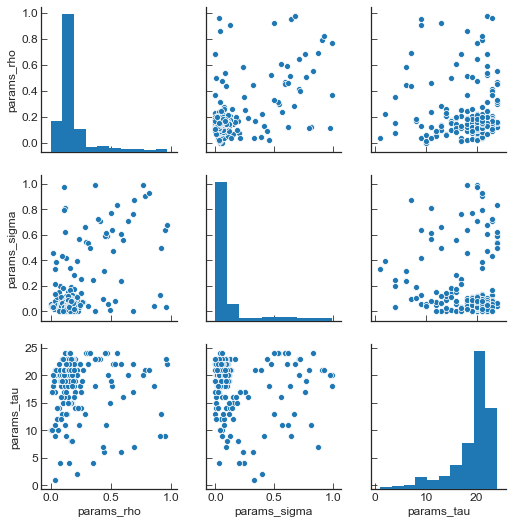

In [124]:
sns.pairplot(optimize_df[["params_rho", "params_sigma", "params_tau"]])

In [125]:
params = study.best_params.copy()
params

{'rho': 0.15294742678708007, 'sigma': 0.042384843885945656, 'tau': 21}

In [126]:
rho, sigma, tau = params["rho"], params["sigma"], params["tau"]
r0 = round(rho / sigma, 2)
r0

3.61